# Exercício de Cálculo de Métricas de Avaliação de Aprendizado - Marco Aurélio Garcia

O presente notebook tem o objetivo de resolver o desafio final do curso de Machine Learning - Cálculo de Métricas de Avaliação de Aprendizado.
Conforme orientação presente em https://academiapme-my.sharepoint.com/:w:/g/personal/kawan_dio_me/Eahgxitum4BBsD3zhtsFCIcBZUMWeOI70Q5XbpWuHfycWQ?e=0pcEXs, as seguintes medias devem ser calculadas a partir dos valores relativos à matriz de confusão para um modelo de classficação:

Sensibilidade = VP / (VP+FN)

Especificidade = VN / (VN+FP)

Acurácia = (VP+VN) / N

Precisão = VP / (VP+FP)

F-Score = 2 x (PxS) / (P+S)


Em alto nível o processo deste notebook pode ser descrito conforme abaixo:

## 1 - Coleta das imagens para classificação 
Obtenção do dataset Cats & Dogs - https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip

## 2 - Tratamento das imagens para utilização com o TensorFlow
As imagens passam por preprocessamento e preparação para serem utilizadas ao longo do processo e uso com o TensorFlow.

## 3 - Criar rede neural para classificação
Definição de uma rede que deverá classificar as imagens.

## 4 - Calcular as métricas de avaliação
Obter as informações sobre a matriz de confusão para calcular as métricas conforme descrição acima.

In [1]:
# Importação dos objetos e bibliotecas necessárias

%matplotlib inline

import os

import random
import numpy as np
import keras
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

import seaborn as sns

import pandas as pd

### 1 - Coleta das imagens para classificação

Download do dataset e descompactação do pacote. 

In [2]:
!echo "Realizando o download do dataset Cats & Dogs"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
!tar -xf kagglecatsanddogs_5340.zip
# !rm kagglecatsanddogs_5340.zip  #Para excluir arquivos em ambiente Linux ou Jupyter Colab
!del kagglecatsanddogs_5340.zip #Para excluir arquivos em ambiente Windows


"Realizando o download do dataset Cats & Dogs"



#=#=#                                                                          
                                                                           0.0%
                                                                           0.1%
                                                                           0.2%
                                                                           0.4%
                                                                           0.6%
                                                                           0.8%
                                                                           1.0%
                                                                           1.3%
#                                                                          1.5%
#                                                                          1.8%
#                                                                          2.1%
#                                      

In [2]:
root = '.\\PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['.\\PetImages\\Cat', '.\\PetImages\\Dog']


### 2 - Tratamento das imagens para utilização com o TensorFlow

Carga das imagens, conversão para formatos adequados, organização dos conjuntos e conversão para tensores

In [3]:
# Função que deve ser utilizada para carregar as imagens e preprocessa-las devolvendo também seu input vector, que é a representação numérica da 
# imagem e que será utilizada para o tensorflow
def get_image(path):
    img = load_img(path, target_size=(224, 224)) 
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [4]:
# Carrega as imagens dos tipos '.jpg','.png','.jpeg' disponíveis nos diretórios ['.\\PetImages\\Cat', '.\\PetImages\\Dog']
# Cria uma lista de dicionários cujas chaves identificam os input vectors como x e as categorias (cat or dog) como y
# Este procedimento foi reutilizado do notebook de exemplo, sendo ajustado para considerar exceções no carregamento das imagens.

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        try:
            img, x = get_image(img_path)
            data.append({'x':np.array(x[0]), 'y':c})
        except Exception as err:
            print("Falha ao carregar o arquivo " + img_path )
        

# count the number of classes
num_classes = len(categories)
print("Quantidade de classes encontradas: ", num_classes)

Falha ao carregar o arquivo .\PetImages\Cat\666.jpg
Falha ao carregar o arquivo .\PetImages\Dog\11702.jpg


C:\Users\mavga\anaconda3\envs\TensorFlowBase\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Quantidade de classes encontradas:  2


In [5]:
# Randomiza as imagens e cria as divisões de treinamento, validação e testes (70%, 15%, 15%)

random.shuffle(data)
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [6]:
# Separa os dados das por rótulos x (variáveis independentes) e y (variável dependente) filtrando pelas chaves do dicionário

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 

In [7]:
# Realiza o pre-processamento dos datasets, convertendo os tipos de dados para float 32 e normalizando os valores

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Converte os conjuntos y para matrizes de classe binária para processamento no tensorflow
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_test.shape: ", y_test.shape)

# Converte os conjuntos em tensores
with tf.device('/CPU:0'):
    x_train_tensor = tf.convert_to_tensor(x_train, np.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, np.float32)
    x_test_tensor = tf.convert_to_tensor(x_test, np.float32)
    y_test_tensor = tf.convert_to_tensor(y_test, np.float32)
    x_val_tensor = tf.convert_to_tensor(x_val, np.float32)
    y_val_tensor = tf.convert_to_tensor(y_val, np.float32)

y_test.shape:  (3750, 2)


In [8]:
# Sumário dos dados que trabalhamos:
print("Foram Carregadas %d imagens pertencentes a %d categorias"%(len(data), num_classes))
print("Conjuntos de treinamento / validação / teste: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Formato dos dados de trainamento (Variáveis independentes): ", x_train.shape)
print("Formato do conjunto y (Variável dependentes): ", y_train.shape)


Foram Carregadas 24998 imagens pertencentes a 2 categorias
Conjuntos de treinamento / validação / teste: 17498, 3750, 3750
Formato dos dados de trainamento (Variáveis independentes):  (17498, 224, 224, 3)
Formato do conjunto y (Variável dependentes):  (17498, 2)


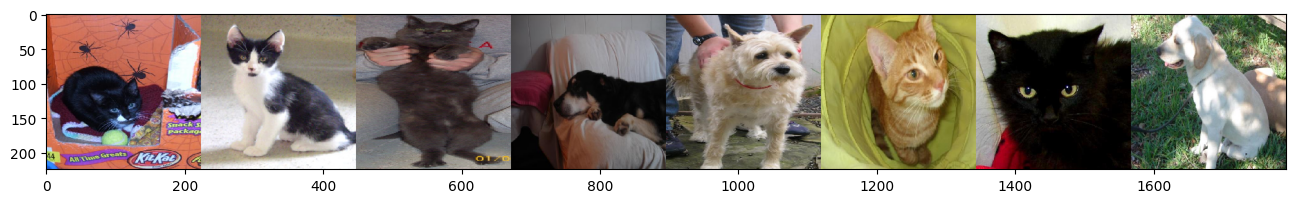

In [9]:
# Algumas imagens carregads por exemplo

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### 3 - Criar rede neural para classificação

A rede utilizada abaixo é o mesmo código compartilhado no jupyter colab sobre transfer learning:

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [10]:
x_train_tensor.shape[1:]

TensorShape([224, 224, 3])

In [11]:
# Construção do modelo
model = Sequential()
print("Input dimensions: ",x_train_tensor.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train_tensor.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

In [12]:
# Compilando o modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[ keras.metrics.CategoricalAccuracy(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(), # Sensibilidade
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(), 
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                      ])

In [13]:
# Treinando o modelo
history = model.fit(x=x_train_tensor, y=y_train_tensor,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val_tensor, y_val_tensor))


Epoch 1/10
547/547 [==============================] - 29s 36ms/step - loss: 0.6215 - categorical_accuracy: 0.6422 - precision: 0.6422 - recall: 0.6422 - true_positives: 11238.0000 - true_negatives: 11238.0000 - false_positives: 6260.0000 - false_negatives: 6260.0000 - val_loss: 0.5615 - val_categorical_accuracy: 0.7149 - val_precision: 0.7149 - val_recall: 0.7149 - val_true_positives: 2681.0000 - val_true_negatives: 2681.0000 - val_false_positives: 1069.0000 - val_false_negatives: 1069.0000
Epoch 2/10
547/547 [==============================] - 19s 35ms/step - loss: 0.5173 - categorical_accuracy: 0.7451 - precision: 0.7451 - recall: 0.7451 - true_positives: 13038.0000 - true_negatives: 13038.0000 - false_positives: 4460.0000 - false_negatives: 4460.0000 - val_loss: 0.4679 - val_categorical_accuracy: 0.7771 - val_precision: 0.7771 - val_recall: 0.7771 - val_true_positives: 2914.0000 - val_true_negatives: 2914.0000 - val_false_positives: 836.0000 - val_false_negatives: 836.0000
Epoch 3/10

In [14]:
len(x_train_tensor)

17498

### 4 - Calcular as métricas de avaliação

Obter as informações sobre a matriz de confusão para calcular as métricas de avaliação do modelo que acabamos de utilizar.


In [15]:
# Utiliza o modelo previamente treinado para prever as classes com o conjunto de validação
y_pred = model.predict(x=x_test_tensor)

# Transforma os conjuntos y previsto e real para classes no formato 0=gato, 1=cão.
y_test_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_val, axis=1)

118/118 [==============================] - 2s 15ms/step


In [16]:
# Captura a matriz de confusão com base nos conjuntos y_val_pred_classes e y_val_classes e a deposita em um pandas dataframe
conf_matr = tf.math.confusion_matrix(labels=y_test_classes, predictions=y_test_pred_classes).numpy()
df_conf_matr = pd.DataFrame(conf_matr, index=categories, columns=categories)
df_conf_matr

,.\PetImages\Cat,.\PetImages\Dog
.\PetImages\Cat,954,885
.\PetImages\Dog,952,959


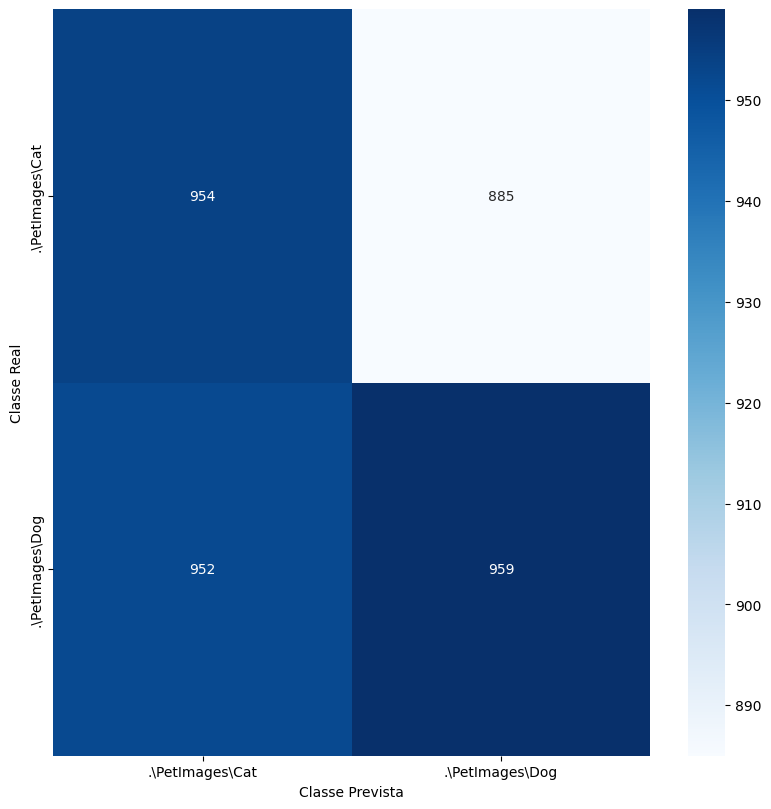

In [17]:
# Mostrando a matriz de confusão como gráfico de calor:
figure = plt.figure(figsize=(8,8))
sns.heatmap(df_conf_matr, annot=True, cmap=plt.cm.Blues, fmt=".0f")
plt.tight_layout()
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()

### Matriz de confusão para classificação binária e multiclasse

Para classificação binária é fácil definir uma classe como sendo positiva e a outra como negativa para daí então identificar os Verdadeiros Positivos, Verdadeiros Negativos, Falsos Positivos e Falsos Negativos; entretanto para casos onde há mais de duas classes, é necessário calcular estes valores para cada classe onde a classe em questão será o positivo e as outras serão o caso negativo, transformando assim o problema em um caso binário.

Sendo assim, vou calcular as métricas de avaliação do modelo inicialmente para cada classe e a partir disso calcularemos para o modelo a média das métrica relativas às classes.


In [19]:
# Calcula os valores de Verdadeiros Positivos, Verdadeiros Negativos, Falsos Positivos e Falsos Negativos para cada classe e
# armazena em dicionários

N = len(y_test_classes)

# valor verdadeiro positivo:  index == classe e column_name == classe
VP = {classe: df_conf_matr[df_conf_matr.apply(lambda x: (x.index == classe) & (x.name == classe))].sum().sum() for classe in categories}

# valor verdadeiro negativo:  index != classe e column_name != classe
VN = {classe: df_conf_matr[df_conf_matr.apply(lambda x: (x.index != classe) & (x.name != classe))].sum().sum() for classe in categories}

# valor falso positivo:  column_name != index e column_name == classe
FP = {classe: df_conf_matr[df_conf_matr.apply(lambda x: (x.name != x.index) & (x.name == classe))].sum().sum() for classe in categories}

# valor falso negativo:  column_name != index e index == classe
FN = {classe: df_conf_matr[df_conf_matr.apply(lambda x: (x.name != x.index) & (x.index == classe))].sum().sum() for classe in categories}

print("Qtd. de itens = %s. \nVP = %s. \nVN = %s. \nFP = %s. \nFN = %s." % (N, VP, VN, FP, FN))

Qtd. de itens = 3750. 
VP = {'.\\PetImages\\Cat': 954.0, '.\\PetImages\\Dog': 959.0}. 
VN = {'.\\PetImages\\Cat': 959.0, '.\\PetImages\\Dog': 954.0}. 
FP = {'.\\PetImages\\Cat': 952.0, '.\\PetImages\\Dog': 885.0}. 
FN = {'.\\PetImages\\Cat': 885.0, '.\\PetImages\\Dog': 952.0}.


In [20]:
# Sensibilidade = VP / (VP+FN)

sum_merged_dict = {key: VP.get(key, 0) + FN.get(key, 0) for key in set(VP) | set(FN)}
div_merged_dict = {key: VP.get(key, 0) / sum_merged_dict.get(key, 0) for key in set(VP) | set(sum_merged_dict)}

SENS = div_merged_dict

In [21]:
# Especificidade = VN / (FP+VN)

sum_merged_dict = {key: FP.get(key, 0) + VN.get(key, 0) for key in set(FP) | set(VN)}
div_merged_dict = {key: VN.get(key, 0) / sum_merged_dict.get(key, 0) for key in set(VN) | set(sum_merged_dict)}

ESPEC = div_merged_dict

In [22]:
# Acurácia = (VP+VN) / N

sum_merged_dict = {key: VP.get(key, 0) + VN.get(key, 0) for key in set(VP) | set(VN)}
div_merged_dict = {key: sum_merged_dict.get(key, 0) / N for key in set(sum_merged_dict)}

ACUR = div_merged_dict

In [23]:
# Precisão = VP / (VP+FP)

sum_merged_dict = {key: VP.get(key, 0) + FP.get(key, 0) for key in set(VP) | set(FP)}
div_merged_dict = {key: VP.get(key, 0) / sum_merged_dict.get(key, 0) for key in set(VP) | set(sum_merged_dict)}

PREC = div_merged_dict

In [24]:
# F-Score = 2 x (PxS) / (P+S)

mult_merged_dict = {key: PREC.get(key, 0) * SENS.get(key, 0) for key in set(PREC) | set(SENS)}
sum_merged_dict = {key: PREC.get(key, 0) + SENS.get(key, 0) for key in set(PREC) | set(SENS)}
div_merged_dict = {key: 2 * mult_merged_dict.get(key, 0) / sum_merged_dict.get(key, 0) for key in set(mult_merged_dict) | set(sum_merged_dict)}

FSCORE = div_merged_dict

In [25]:
print("Sensibilidade = %s. \nEspecificidade = %s. \nAcurácia = %s. \nPrecisão = %s. \nF-Score = %s." % (SENS, ESPEC, ACUR, PREC, FSCORE))

Sensibilidade = {'.\\PetImages\\Dog': 0.5018315018315018, '.\\PetImages\\Cat': 0.5187601957585645}. 
Especificidade = {'.\\PetImages\\Dog': 0.5187601957585645, '.\\PetImages\\Cat': 0.5018315018315018}. 
Acurácia = {'.\\PetImages\\Dog': 0.5101333333333333, '.\\PetImages\\Cat': 0.5101333333333333}. 
Precisão = {'.\\PetImages\\Dog': 0.5200650759219089, '.\\PetImages\\Cat': 0.5005246589716684}. 
F-Score = {'.\\PetImages\\Dog': 0.5107856191744341, '.\\PetImages\\Cat': 0.509479305740988}.


In [26]:
Mean_SENS, Mean_ESPEC, Mean_ACUR, Mean_PREC, Mean_FSCORE = np.mean(list(SENS.values())), np.mean(list(ESPEC.values())) , np.mean(list(ACUR.values())) , np.mean(list(PREC.values())) , np.mean(list(FSCORE.values())) 

In [27]:
print("Média das Métricas calculadas para as classes do dataset\n")
print("Sensibilidade = %s. \nEspecificidade = %s. \nAcurácia = %s. \nPrecisão = %s. \nF-Score = %s." % (Mean_SENS, Mean_ESPEC, Mean_ACUR, Mean_PREC, Mean_FSCORE))

Média das Métricas calculadas para as classes do dataset

Sensibilidade = 0.5102958487950331. 
Especificidade = 0.5102958487950331. 
Acurácia = 0.5101333333333333. 
Precisão = 0.5102948674467886. 
F-Score = 0.510132462457711.
